In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,RepeatVector,TimeDistributed
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout,GlobalMaxPooling1D

from utils.data_split import split_sequence_parallel
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\InfoGainTiantandata.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [3]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
scaler9 = MinMaxScaler(feature_range=(0, 1))
scaler10 = MinMaxScaler(feature_range=(0, 1))
scaler11 = MinMaxScaler(feature_range=(0, 1))
scaler12 = MinMaxScaler(feature_range=(0, 1))
scaler13 = MinMaxScaler(feature_range=(0, 1))
scaler14 = MinMaxScaler(feature_range=(0, 1))
scaler15 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['PM2.5']=scaler1.fit_transform(data_minmax['PM2.5'].values.reshape(-1,1))
data_minmax['PM10']=scaler2.fit_transform(data_minmax['PM10'].values.reshape(-1,1))
data_minmax['SO2']=scaler3.fit_transform(data_minmax['SO2'].values.reshape(-1,1))
data_minmax['NO2']=scaler4.fit_transform(data_minmax['NO2'].values.reshape(-1,1))
data_minmax['CO']=scaler5.fit_transform(data_minmax['CO'].values.reshape(-1,1))
data_minmax['O3']=scaler6.fit_transform(data_minmax['O3'].values.reshape(-1,1))
data_minmax['TEMP']=scaler7.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler8.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['DEWP']=scaler9.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['wd_E']=scaler10.fit_transform(data_minmax['wd_E'].values.reshape(-1,1))
data_minmax['wd_ENE']=scaler11.fit_transform(data_minmax['wd_ENE'].values.reshape(-1,1))
data_minmax['wd_ESE']=scaler12.fit_transform(data_minmax['wd_ESE'].values.reshape(-1,1))
data_minmax['wd_NE']=scaler13.fit_transform(data_minmax['wd_NE'].values.reshape(-1,1))
data_minmax['wd_NW']=scaler14.fit_transform(data_minmax['wd_NW'].values.reshape(-1,1))
data_minmax['wd_SW']=scaler15.fit_transform(data_minmax['wd_SW'].values.reshape(-1,1))

In [4]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = -10200
cast2 = -2880
cast3 = -1416                                                                      
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:cast3] 
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [5]:
data_train

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,wd_E,wd_ENE,wd_ESE,wd_NE,wd_NW,wd_SW
Unnamed: 0,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.232274,0.209939,0.023598,0.414226,0.373737,0.003818,0.246978,0.681239,0.422777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-01 01:00:00,0.220049,0.187627,0.016257,0.393305,0.343434,0.003818,0.229706,0.668488,0.436817,0.000000,0.000000,0.000000,0.138889,0.000000,0.000000
2016-01-01 02:00:00,0.213936,0.191684,0.016257,0.389121,0.363636,0.003818,0.208981,0.666667,0.436817,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000
2016-01-01 03:00:00,0.234719,0.206897,0.023598,0.405858,0.404040,0.003818,0.227979,0.655738,0.430577,0.000000,0.178571,0.000000,0.000000,0.000000,0.000000
2016-01-01 04:00:00,0.215159,0.182556,0.027269,0.397490,0.373737,0.003818,0.202073,0.641166,0.430577,0.192308,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-01 05:00:00,0.160147,0.133874,0.027269,0.372385,0.292929,0.002333,0.191710,0.630237,0.421217,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2016-01-01 06:00:00,0.122249,0.104462,0.023598,0.364017,0.242424,0.002333,0.181347,0.619308,0.419657,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000
2016-01-01 07:00:00,0.121027,0.106491,0.016257,0.343096,0.272727,0.002333,0.172712,0.619308,0.416537,0.134615,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-01 08:00:00,0.129584,0.118661,0.016257,0.347280,0.303030,0.002333,0.172712,0.621129,0.413417,0.000000,0.107143,0.000000,0.000000,0.000000,0.000000


In [6]:
data_test = np.array(data_test)
data_train = np.array(data_train)
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [7]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [8]:
def channel_attention(input):

    filters = input._keras_shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se = multiply([input, se])
    return se

In [9]:
def C2Guard():
    ip = Input(shape=(sw_width,features))

    y = Conv1D(64, 5,kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = Conv1D(64, 3,kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = GlobalAveragePooling1D()(y)
    y = RepeatVector(pred_length)(y)
    
    x = LSTM(128,activation="relu")(ip)
#     x = Dropout(0.2)(x)
    x = RepeatVector(pred_length)(x)
    x = LSTM(64,activation="relu",return_sequences=True)(x)
#     x = Dropout(0.2)(x)
    
    x = concatenate([x, y])
    
    x = TimeDistributed(Dense(16,activation="relu"))(x)
    out = TimeDistributed(Dense(1))(x)

    model = Model(ip, out)
    model.summary()


    return model

In [10]:
model = C2Guard()
model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 21, 15)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 17, 64)       4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 17, 64)       256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 17, 64)       0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [21]:
y = y.reshape(y.shape[0],y.shape[1],1)

In [22]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\C2Guard_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]
starttime=time.time()
model.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = model.fit(X,y,validation_split=0.25,epochs=70, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5466 samples, validate on 1822 samples
Epoch 1/70
 - 7s - loss: 0.1995 - val_loss: 0.0590

Epoch 00001: val_loss improved from inf to 0.05897, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\CTmodel1_weights_best.hdf5
Epoch 2/70
 - 5s - loss: 0.0623 - val_loss: 0.0474

Epoch 00002: val_loss improved from 0.05897 to 0.04737, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\CTmodel1_weights_best.hdf5
Epoch 3/70
 - 5s - loss: 0.0577 - val_loss: 0.0422

Epoch 00003: val_loss improved from 0.04737 to 0.04220, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\CTmodel1_weights_best.hdf5
Epoch 4/70
 - 6s - loss: 0.0557 - val_loss: 0.0455

Epoch 00004: val_loss did not improve from 0.04220
Epoch 5/70
 - 5s - loss: 0.0539 - val_loss: 0.0409

Epoch 00005: val_loss improved from 0.04220 to 0.04089, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\CTmodel1_weights_best.hdf5
Epoch 6/70
 - 5s - loss: 0.0531 - val_loss: 0.0391

Epoch 000

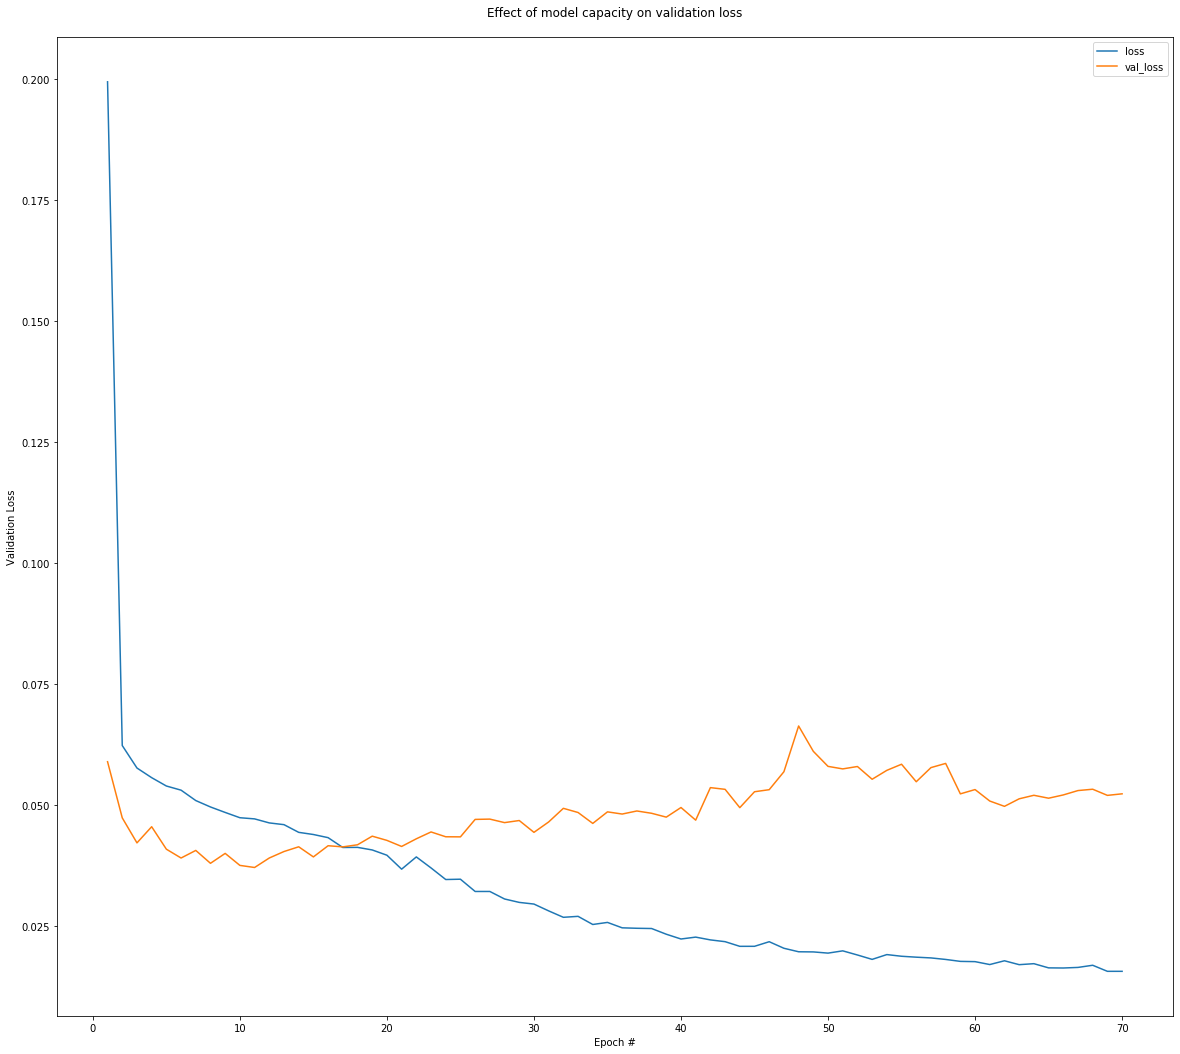

In [24]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(70) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [11]:
filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\C2Guard_weights_best.hdf5"
model.load_weights(filepath)

In [12]:
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1],1)

In [13]:
predict=model.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [14]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1])))).numpy().mean()

53.53882162491114

In [15]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))).numpy().mean()

46.37926381318596

In [19]:
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,:6])).numpy().mean())
print(tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,:6]).numpy().mean())
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,6:])).numpy().mean())
print(tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,6:]).numpy().mean())

40.04654570409533
35.68958034584198
61.02317974574938
57.06894728052994


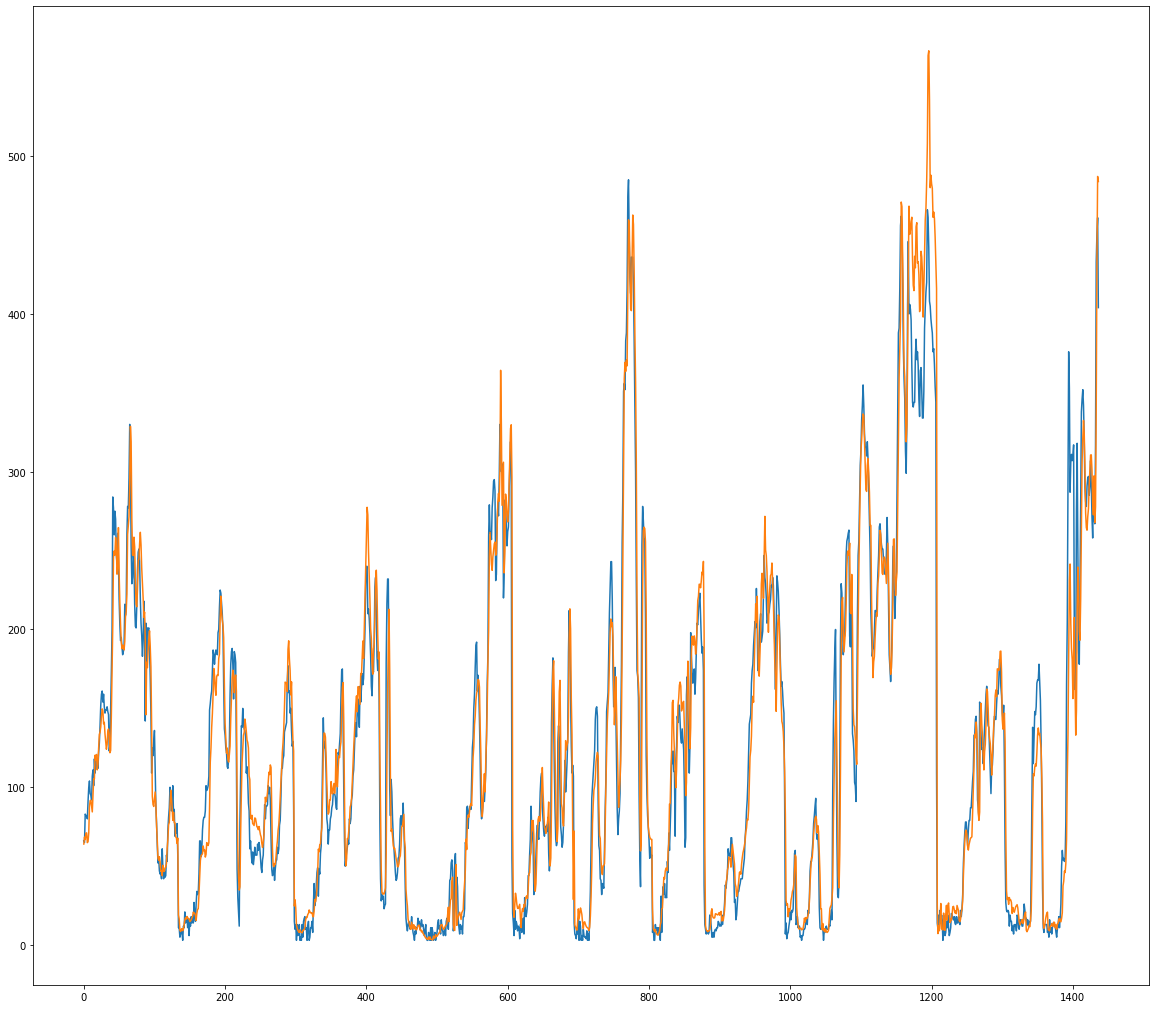

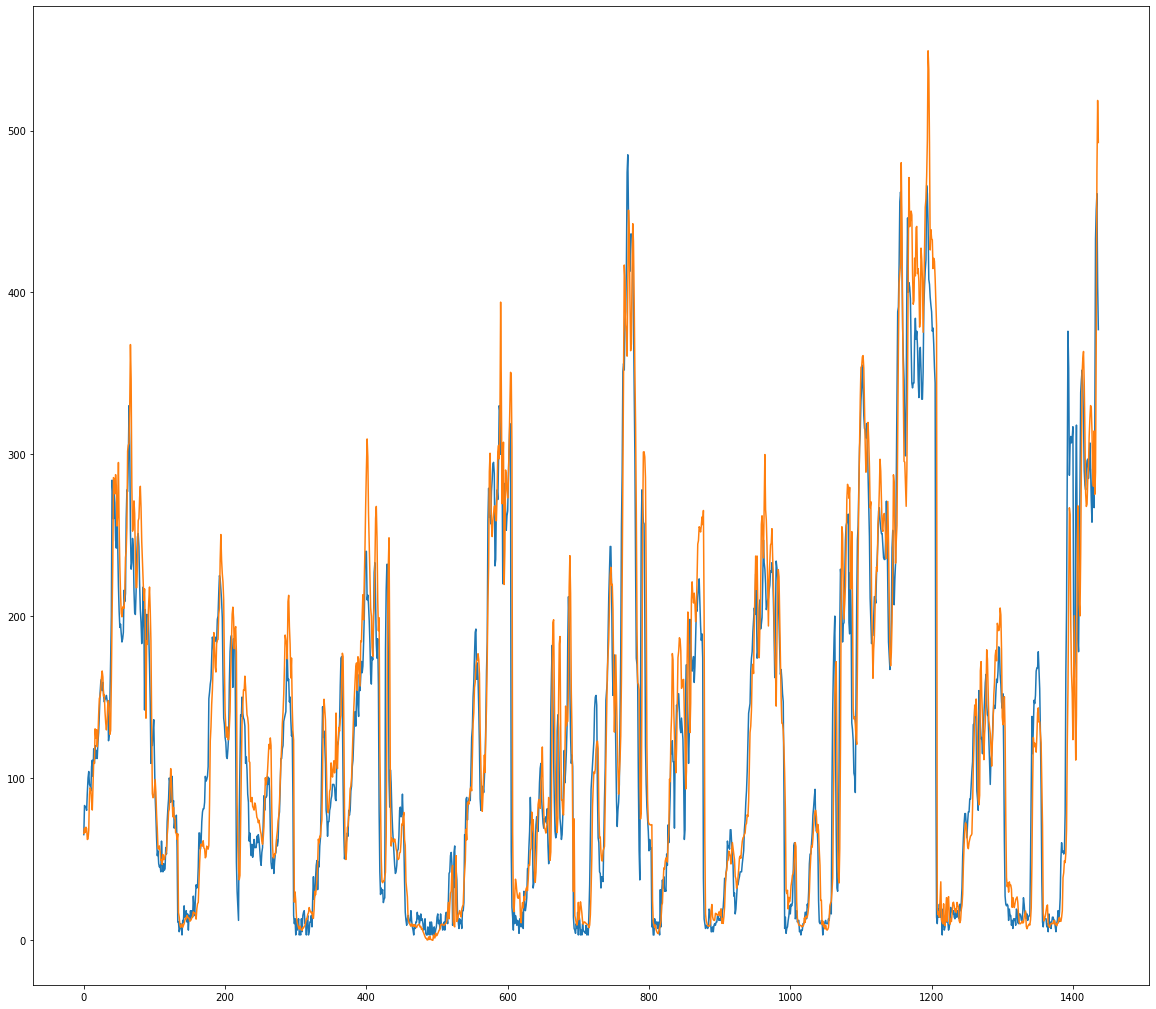

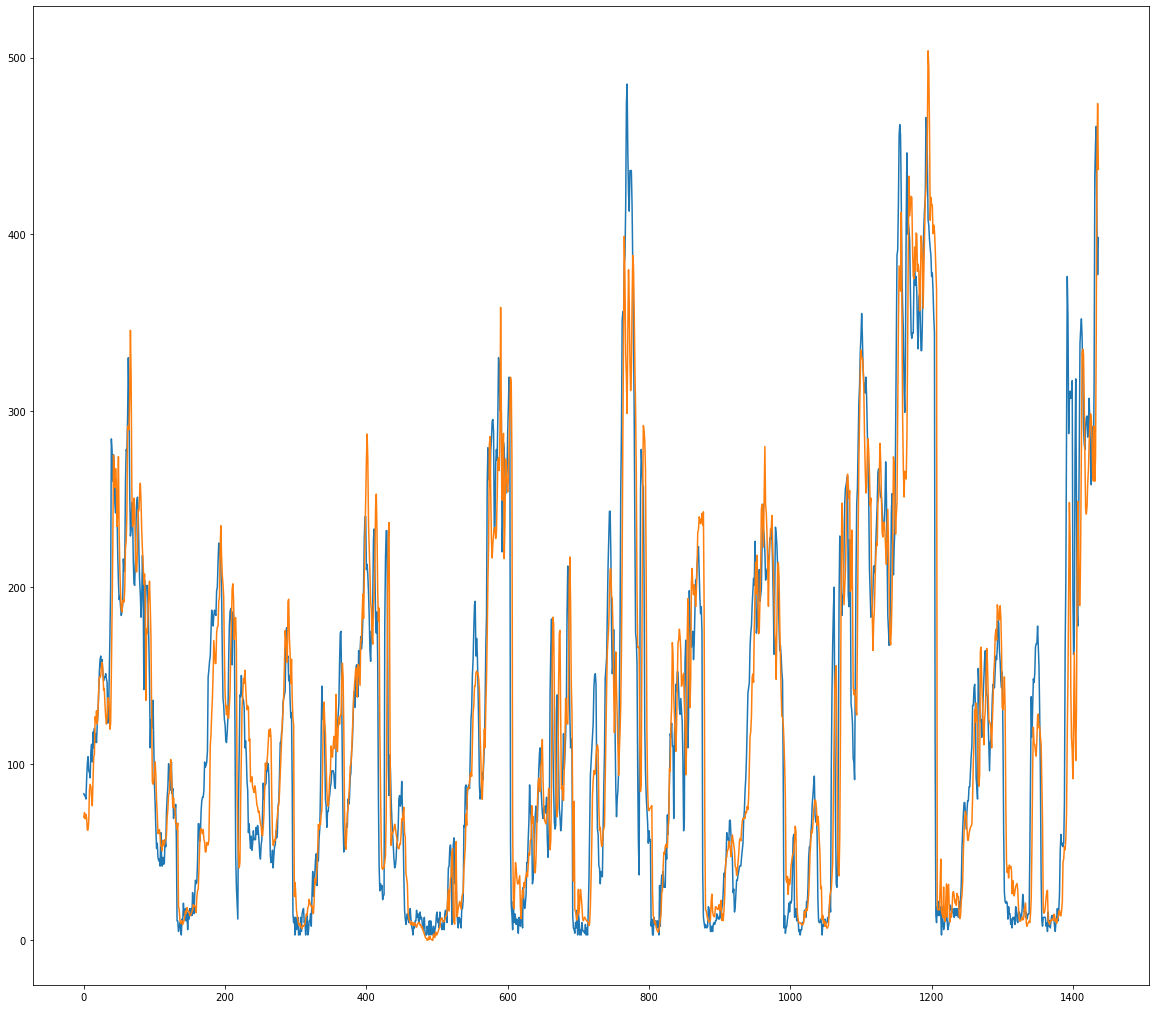

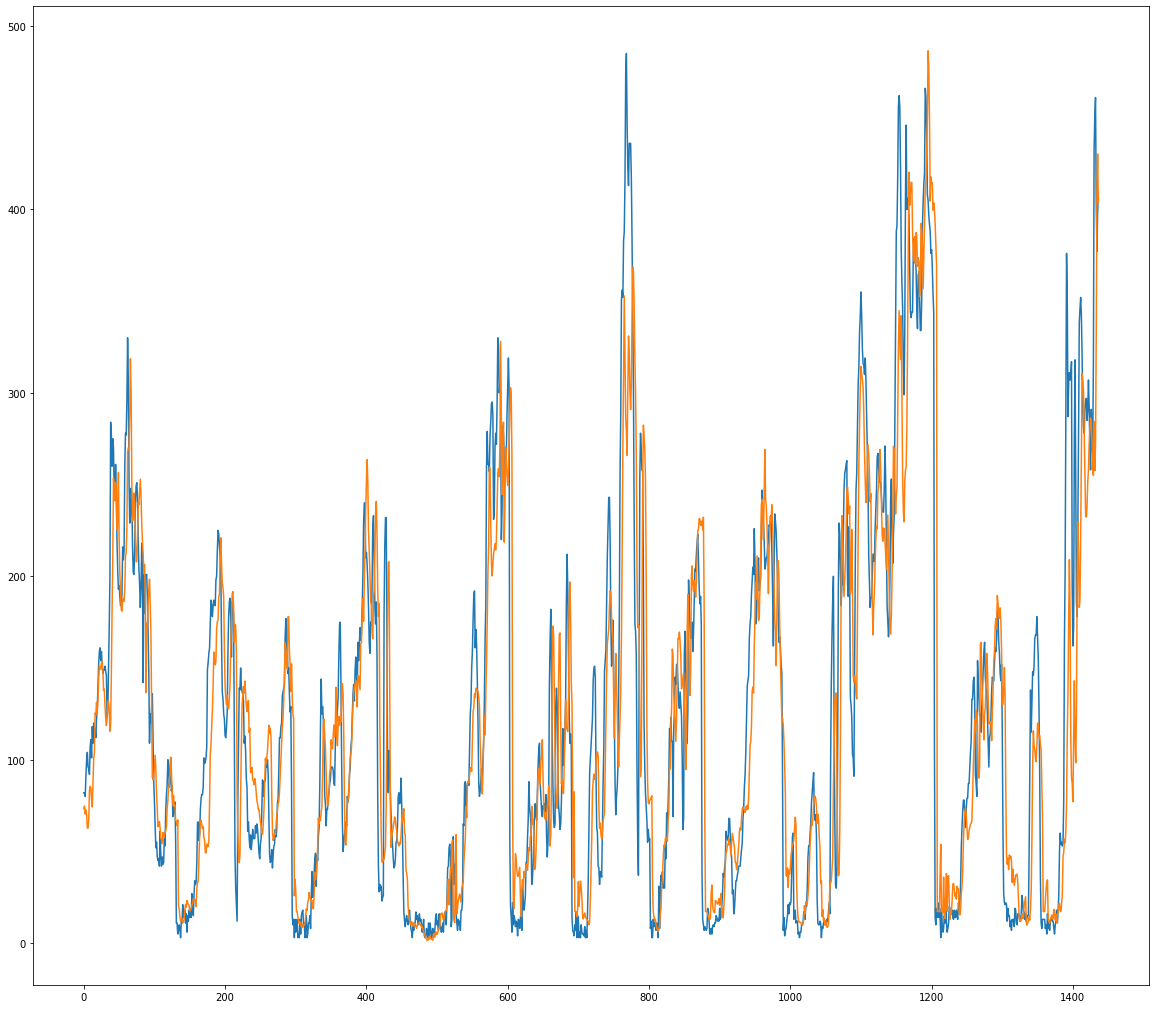

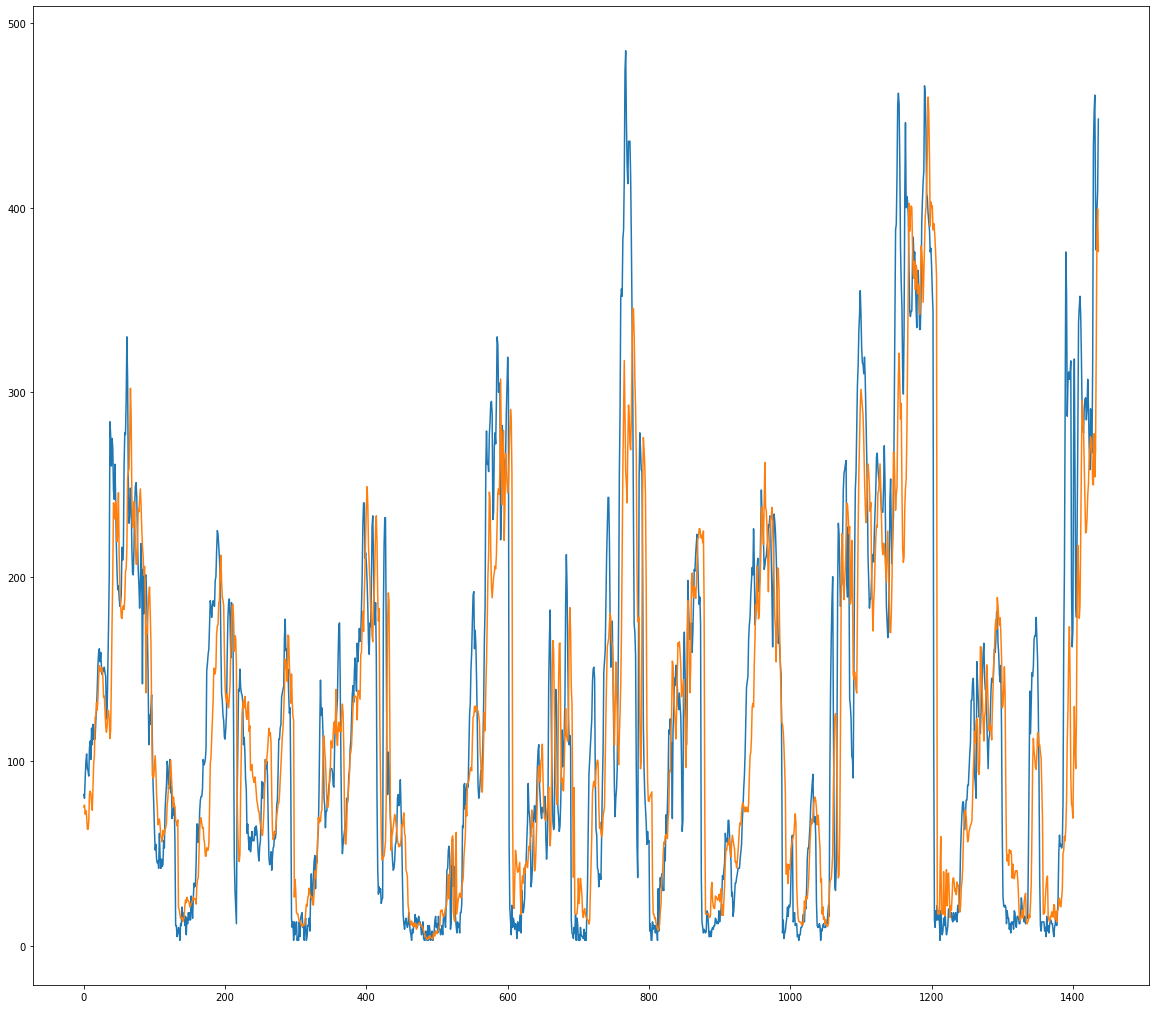

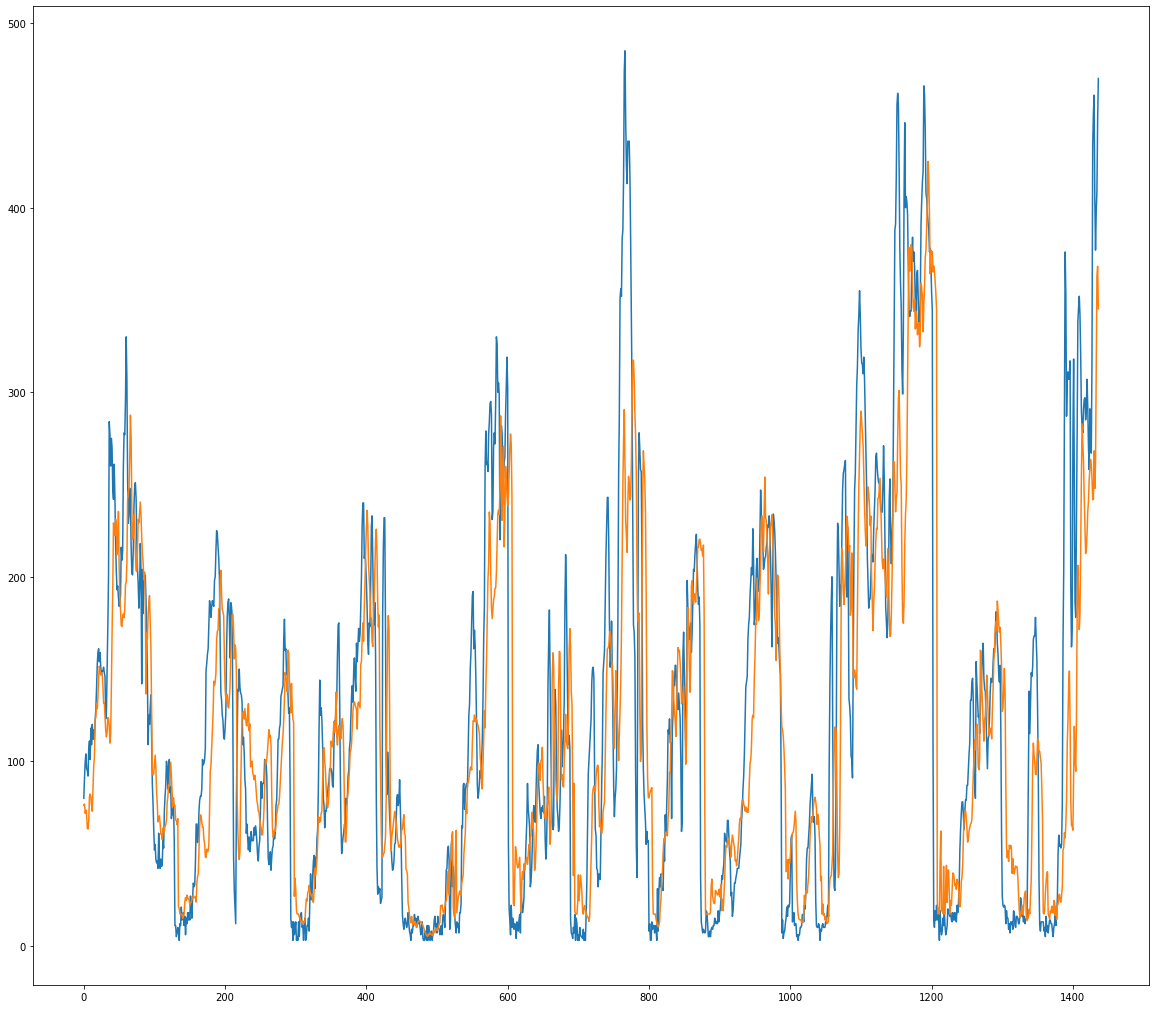

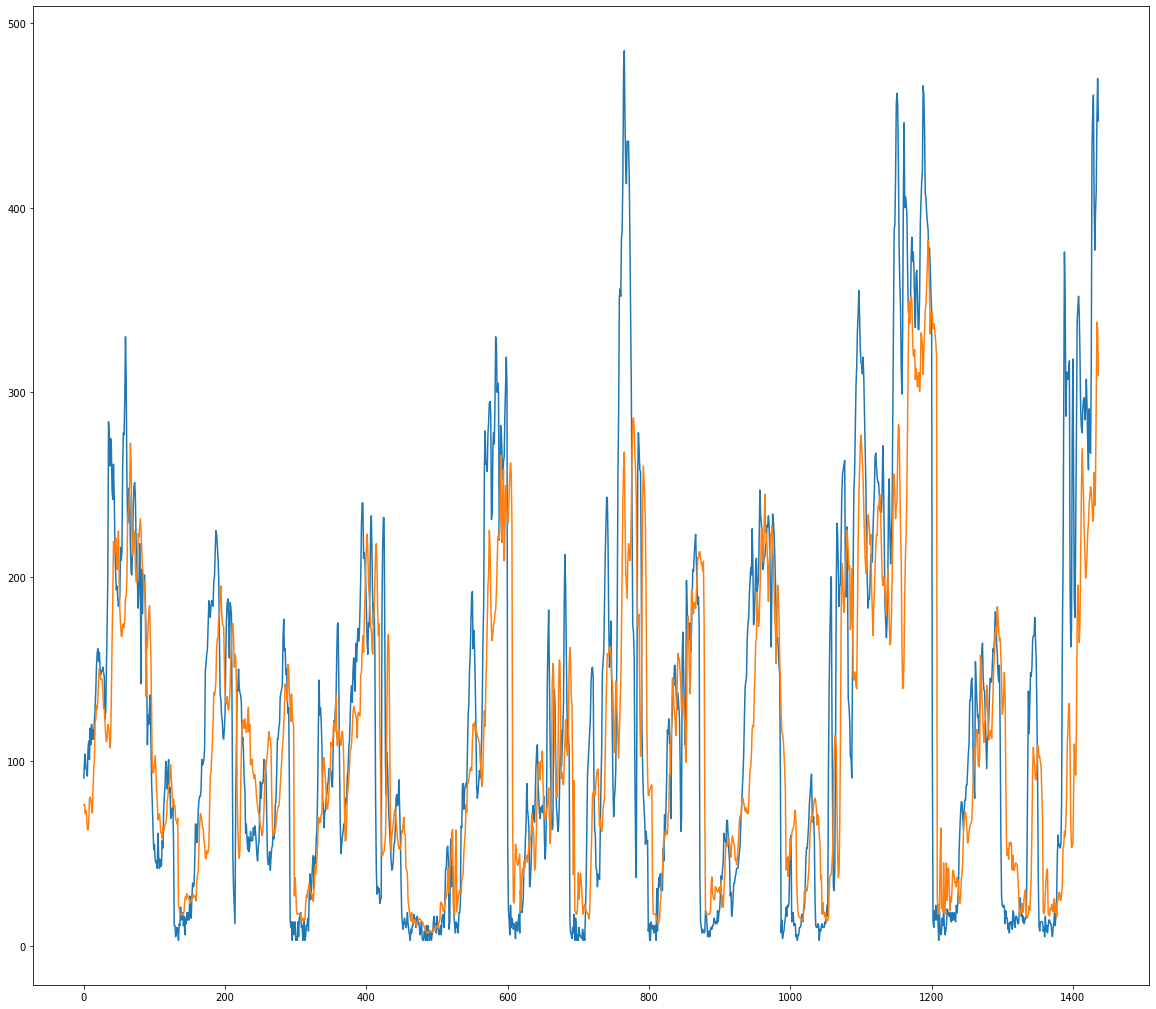

In [17]:
for i in range(7):
    plt.figure(figsize=(20,18))
    plt.plot(scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,i])
    plt.plot(predict[:,i])
    plt.show()

In [17]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,i])).numpy()
    print(i,":",loss1)

0 : 30.316638675645233
1 : 41.83863021474328
2 : 49.49465767944782
3 : 56.908810420267315
4 : 63.007456033201606
5 : 68.26439858195891
6 : 73.35632057609527


In [18]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,i])).numpy()
    print(i,":",loss1)

0 : 4.348423066760916
1 : 5.119522585561533
2 : 5.548247812956112
3 : 6.005423422251607
4 : 6.3719710099711415
5 : 6.702027493839158
6 : 7.0055668167728635


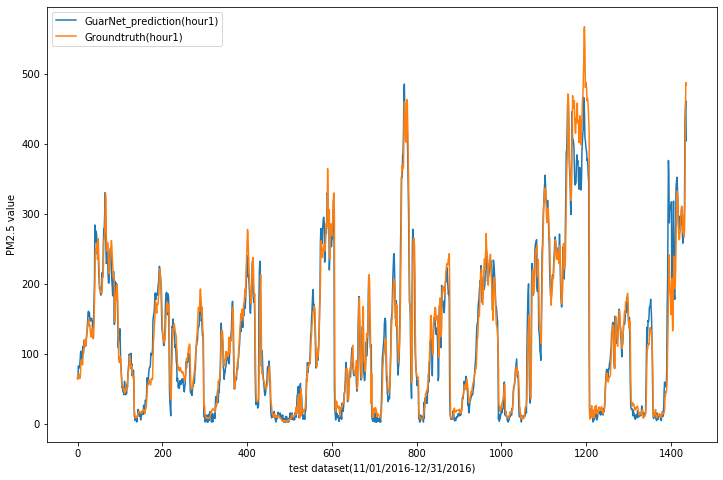

In [24]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,0],label='GuarNet_prediction(hour1)')
plt.plot(predict[:,0],label='Groundtruth(hour1)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,3],label='GuardNet_prediction(hour4)')
plt.plot(predict[:,3],label='Groundtruth(hour4)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

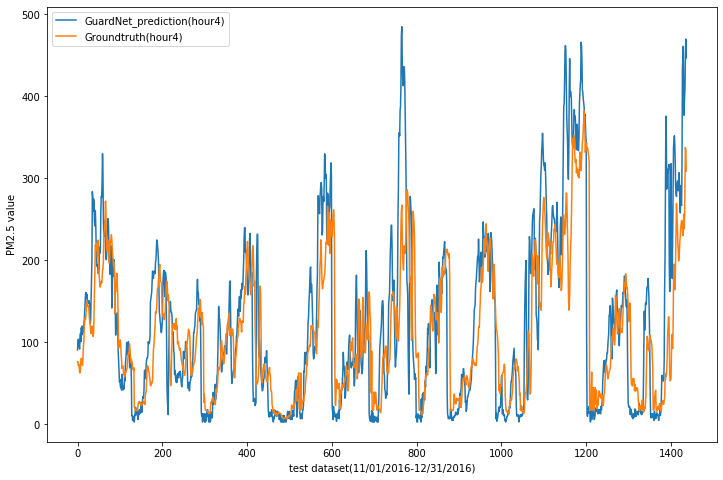

In [26]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1]))[:,6],label='GuardNet_prediction(hour4)')
plt.plot(predict[:,6],label='Groundtruth(hour4)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

# ablation study1

In [69]:
def channel_attention(input):

    filters = input._keras_shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se2 = GlobalMaxPooling1D()(input)
    se2 = Reshape((1, filters))(se2)
    se2 = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se2)
    se2 = Dropout(0.5)(se2)
    se2 = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias=False)(se2)
    se2 = Dropout(0.5)(se2)
    se = multiply([input, se2])
    return se

In [70]:
def CTattentionNET2():
    ip = Input(shape=(sw_width,features))

    y = Conv1D(128, 7,kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = Conv1D(128, 7,kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = GlobalAveragePooling1D()(y)
    y = RepeatVector(pred_length)(y)
    
    x = LSTM(128,activation="relu")(ip)
#     x = Dropout(0.2)(x)
    x = RepeatVector(pred_length)(x)
    x = LSTM(64,activation="relu",return_sequences=True)(x)
#     x = Dropout(0.2)(x)
    
    x = concatenate([x, y])
    
    x = TimeDistributed(Dense(16,activation="relu"))(x)
    out = TimeDistributed(Dense(1))(x)

    model = Model(ip, out)
    model.summary()


    return model

In [71]:
model = CTattentionNET2()
model

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 21, 15)       0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 15, 128)      13568       input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 15, 128)      512         conv1d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 15, 128)      0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [72]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel2_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]
starttime=time.time()
model.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = model.fit(X,y,validation_split=0.25,epochs=60, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5469 samples, validate on 1824 samples
Epoch 1/60
 - 6s - loss: 0.1955 - val_loss: 0.0557

Epoch 00001: val_loss improved from inf to 0.05574, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel2_weights_best.hdf5
Epoch 2/60
 - 5s - loss: 0.0689 - val_loss: 0.0540

Epoch 00002: val_loss improved from 0.05574 to 0.05401, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel2_weights_best.hdf5
Epoch 3/60
 - 5s - loss: 0.0650 - val_loss: 0.0541

Epoch 00003: val_loss did not improve from 0.05401
Epoch 4/60
 - 5s - loss: 0.0615 - val_loss: 0.0482

Epoch 00004: val_loss improved from 0.05401 to 0.04820, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel2_weights_best.hdf5
Epoch 5/60
 - 5s - loss: 0.0593 - val_loss: 0.0446

Epoch 00005: val_loss improved from 0.04820 to 0.04456, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel2_weights_best.hdf5
Epoch 6/60
 - 5s - loss: 0.0552 - val_loss: 0.0455

Epoch 00006: val_loss did not imp

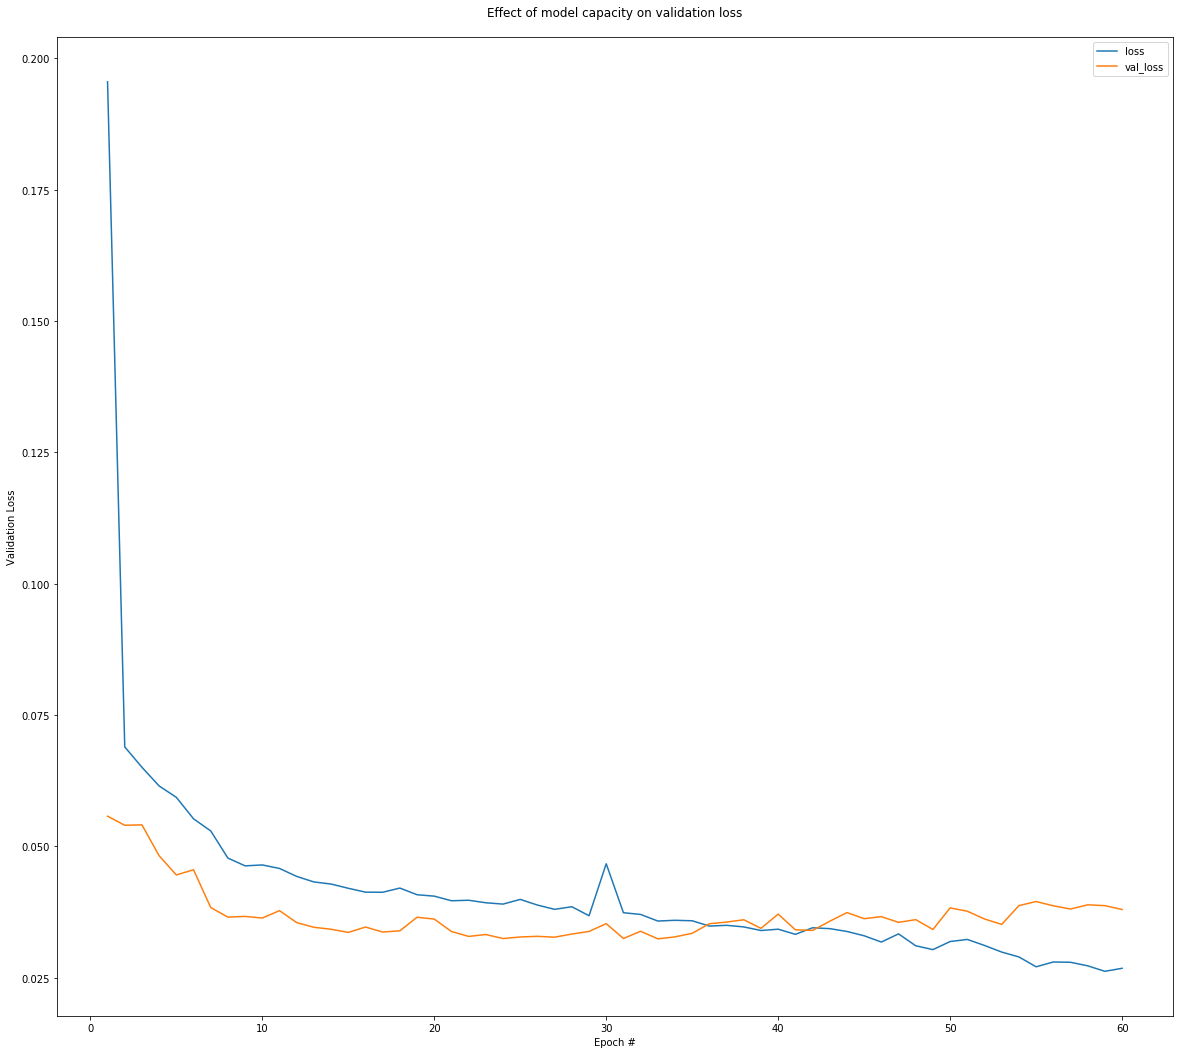

In [73]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(60) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [74]:
model.load_weights(filepath)

In [75]:
test_y = test_y.reshape(test_y.shape[0],test_y.shape[1],1)

In [76]:
predict=model.predict(test_x)
predict=scaler1.inverse_transform(predict.reshape(predict.shape[0],predict.shape[1]))

In [77]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1])))).numpy().mean()

43.445880930445995

In [78]:
tf.sqrt(tf.losses.mae(predict,scaler1.inverse_transform(test_y.reshape(test_y.shape[0],test_y.shape[1])))).numpy().mean()

5.5154557537627005

# ablation study2

In [79]:
def channel_attention(input):

    filters = input._keras_shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dropout(0.5)(se)
    se2 = GlobalMaxPooling1D()(input)
    se2 = Reshape((1, filters))(se2)
    se2 = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se2)
    se2 = Dropout(0.5)(se2)
    se2 = Dense(filters, activation='relu', kernel_initializer='he_normal', use_bias=False)(se2)
    se2 = Dropout(0.5)(se2)
    se = multiply([input, se,se2])
    return se

In [99]:
def CTattentionNET3():
    ip = Input(shape=(sw_width,features))

    y = Conv1D(128, 7,kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = Conv1D(128, 7,kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = channel_attention(y)
    
    y = GlobalAveragePooling1D()(y)
    
    x = LSTM(128,activation="relu")(ip)
    x = Dropout(0.8)(x)
    
    x = concatenate([x, y])
    
    out = Dense(pred_length,activation='relu')(x)

    model = Model(ip, out)
    model.summary()


    return model

In [100]:
model = CTattentionNET3()
model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 21, 15)       0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 15, 128)      13568       input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 15, 128)      512         conv1d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 15, 128)      0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [101]:
y = y.reshape((y.shape[0],y.shape[1]))

In [102]:
y.shape

(7293, 7)

In [103]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel3_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]
starttime=time.time()
model.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = model.fit(X,y,validation_split=0.25,epochs=60, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5469 samples, validate on 1824 samples
Epoch 1/60
 - 6s - loss: 0.2450 - val_loss: 0.0523

Epoch 00001: val_loss improved from inf to 0.05226, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel3_weights_best.hdf5
Epoch 2/60
 - 4s - loss: 0.0630 - val_loss: 0.0368

Epoch 00002: val_loss improved from 0.05226 to 0.03683, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel3_weights_best.hdf5
Epoch 3/60
 - 4s - loss: 0.0545 - val_loss: 0.0379

Epoch 00003: val_loss did not improve from 0.03683
Epoch 4/60
 - 4s - loss: 0.0565 - val_loss: 0.0366

Epoch 00004: val_loss improved from 0.03683 to 0.03658, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel3_weights_best.hdf5
Epoch 5/60
 - 4s - loss: 0.0514 - val_loss: 0.0341

Epoch 00005: val_loss improved from 0.03658 to 0.03412, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\weights\CTmodel3_weights_best.hdf5
Epoch 6/60
 - 4s - loss: 0.0502 - val_loss: 0.0353

Epoch 00006: val_loss did not imp

In [104]:
model.load_weights(filepath)

In [105]:
test_y = test_y.reshape((test_y.shape[0],test_y.shape[1]))

In [106]:
predict=model.predict(test_x)
predict=scaler1.inverse_transform(predict)

In [107]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

44.7745038249285

In [109]:
tf.sqrt(tf.losses.mae(predict,scaler1.inverse_transform(test_y))).numpy().mean()

5.718689942710542